In [ ]:
from pysmartworkcell.vlm_utils import (
    load_models, 
    predict_and_annotate, 
    estimate_axes_from_pcl, draw_and_show_axes,
    get_pcl_from_mask, axes2matrix
)
from pysmartworkcell import (
    calibration_utils as calib_utils,
    vlm_utils, 
    realsense_utils as rs_utils
)
import yaml
from PIL import Image
import numpy as np
import torch
import cv2
import supervision as sv
import matplotlib.pyplot as plt

In [16]:
from pathlib import Path

current_path = Path.cwd()

# Search upward for the folder named "SmartWorkcell"
for parent in current_path.parents:
    if (parent / "config").exists() and (parent / "src/SmartWorkcell").exists():
        PROJECT_ROOT = parent
        break
else:
    raise RuntimeError("SmartWorkcell root not found")

DEVICE = 'cuda'
CONFIG_DIR = PROJECT_ROOT / "config"
IO_DIR = PROJECT_ROOT / "io"
SRC_DIR = PROJECT_ROOT / "src"
print(f'config dir: {CONFIG_DIR}\nio dir: {IO_DIR}\nsrc dir: {SRC_DIR}')


config dir: /home/non/nhan_ws/src/SmartWorkcell/config
io dir: /home/non/nhan_ws/src/SmartWorkcell/io
src dir: /home/non/nhan_ws/src/SmartWorkcell/src


In [17]:
IMAGE = IO_DIR / "test" / "bottle.png"
TEXT = 'teach pendant. keyboard. water bottle'

# Load gdino & sam predictor
gdino, predictor = load_models(
    gdino_checkpoint='../../config/gdino/weights/groundingdino_swinb_cogcoor.pth',
    gdino_config='../../config/gdino/GroundingDINO_SwinB_cfg.py',
    sam_image_encoder='../../config/nanosam/data/resnet18_image_encoder.engine',
    sam_mask_decoder='../../config/nanosam/data/mobile_sam_mask_decoder.engine'
)

final text_encoder_type: bert-base-uncased


[10/16/2025-20:58:29] [TRT] [W] WARNING The logger passed into createInferRuntime differs from one already registered for an existing builder, runtime, or refitter. So the current new logger is ignored, and TensorRT will use the existing one which is returned by nvinfer1::getLogger() instead.
[10/16/2025-20:58:29] [TRT] [W] WARNING The logger passed into createInferRuntime differs from one already registered for an existing builder, runtime, or refitter. So the current new logger is ignored, and TensorRT will use the existing one which is returned by nvinfer1::getLogger() instead.


[10/16/2025-20:58:30] [TRT] [W] Using default stream in enqueueV3() may lead to performance issues due to additional calls to cudaStreamSynchronize() by TensorRT to ensure correct synchronization. Please use non-default stream instead.
[10/16/2025-20:58:30] [TRT] [W] Using default stream in enqueueV3() may lead to performance issues due to additional calls to cudaStreamSynchronize() by TensorRT to ensure correct synchronization. Please use non-default stream instead.


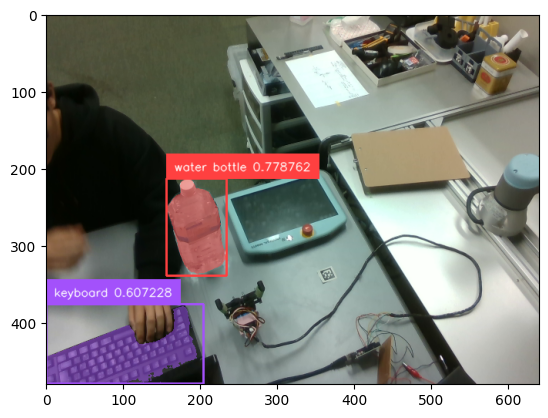

In [18]:
labels, bboxes, results = predict_and_annotate(gdino, predictor, IMAGE, TEXT)

In [19]:
# load depth
DEPTH = IO_DIR / 'test' / 'bottle_depth.npy'
depth = np.load(DEPTH)

# Load camera matrix
with open(CONFIG_DIR / 'realsense_origin.yaml') as f:
    data = yaml.safe_load(f)
cam_mtx = np.array(data['camera_matrix'], dtype=np.float32)
depth_scale = float(data['depth_scale'])

obj_list = []
for result in results:
    mask = result['segmentation']
    pcl = get_pcl_from_mask(mask, depth, cam_mtx=cam_mtx, depth_scale=depth_scale)
    axes, centroid = estimate_axes_from_pcl(pcl)
    obj = {
        'pcl': pcl,
        'axes': axes,
        'centroid': centroid,
        'T_cam_obj': axes2matrix(axes=axes, centroid=centroid) # obj pose in cam (transformation mtx from camera to obj)
    }
    obj_list.append(obj)

In [20]:
axes_list = [obj['axes'] for obj in obj_list]
pcl_list = [obj['pcl'] for obj in obj_list]

In [21]:
draw_and_show_axes(pcl_list=pcl_list, axes_list=axes_list, axis_length=0.4)

In [ ]:
# Compute object pose in robot frame
T_cam_obj_list = [obj['T_cam_obj'] for obj in obj_list]
ids, T_list_cam_robot = calib_utils.load_transform_mtx(CONFIG_DIR / 'cam2robot.yaml')
T_robot_cam_list = [calib_utils.invert_transform(T) for T in T_list_cam_robot]
T_robot_obj_list = [T_rc @ Tco for T_rc, Tco in zip(T_robot_cam_list, T_cam_obj_list)]
calib_utils.save_transform_mtx(ids=ids, T_list=T_robot_obj_list, path=CONFIG_DIR/'robot2obj.yaml')

[INFO] Saved transforms to /home/non/nhan_ws/src/SmartWorkcell/config/robot2obj.yaml


In [24]:
poses = [calib_utils.matrix2pose(T) for T in T_robot_obj_list]
poses

[position: 
   x: 0.16803431563621213
   y: 0.5251743721267418
   z: 0.3127191453683629
 orientation: 
   x: -0.7418297474688185
   y: -0.3286557837843568
   z: -0.19743925337548748
   w: 0.5501742840064133,
 position: 
   x: -1.1589536666870117
   y: -0.008942165970802302
   z: 0.37970197200775146
 orientation: 
   x: 0.8496389172379105
   y: -0.3264953028826307
   z: -0.37163901258665993
   w: 0.1827538558662507]